<a href="https://colab.research.google.com/github/modhudeb/ai_course_temp/blob/main/Pnemonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import os
import logging
import zipfile
import cv2
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Loading Images

In [ ]:
zip_loc = '/content/drive/MyDrive/data/files/chest_xray.zip'
extract_loc = '/content/drive/MyDrive/data/files/chest_xray/'
log_loc = '/content/logs/'
os.makedirs(log_loc, exist_ok=True)

In [ ]:
logger = logging.getLogger('Data-Handler')
logger.setLevel('DEBUG')

ch = logging.StreamHandler()
ch.setLevel('DEBUG')

fh = logging.FileHandler(os.path.join(log_loc, 'data_hisoty.log'))
fh.setLevel('DEBUG')

formatter = logging.Formatter("%(asctime)s - [%(levelname)s] - %(message)s",
                              datefmt="%Y-%m-%d %H:%M:%S")

ch.setFormatter(formatter)
fh.setFormatter(formatter)

logger.addHandler(ch)
logger.addHandler(fh)

In [ ]:
# !!!!!
def unzip_file(zip_loc:str, extract_loc:str):
    try:
        os.makedirs(extract_loc, exist_ok=True)
        with zipfile.ZipFile(zip_loc, 'r') as zf:
            logger.info(f'Extracting file to {extract_loc}')
            zf.extractall(extract_loc)
            logger.debug(f'Extracted {len(zf.namelist())} files...')
    except Exception as e:
        logger.error('Zip file not found...')




unzip_file(zip_loc, extract_loc)

2025-08-23 17:21:10 - [INFO] - Extracting file to /content/drive/MyDrive/data/files/chest_xray/
INFO:Data-Handler:Extracting file to /content/drive/MyDrive/data/files/chest_xray/
2025-08-23 17:24:22 - [DEBUG] - Extracted 5861 files...
DEBUG:Data-Handler:Extracted 5861 files...


# Preprocess


In [ ]:
# ------------------ Helper Functions ------------------
def apply_clahe(img: np.ndarray) -> np.ndarray:
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_uint8 = np.uint8(img)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_uint8 = clahe.apply(img_uint8)
    img_uint8 = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2RGB)
    return img_uint8


def apply_sobel(img: np.ndarray) -> np.ndarray:
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(sobelx, sobely)
    return np.uint8(np.clip(sobel, 0, 255))

def apply_laplacian(img: np.ndarray) -> np.ndarray:
    lap = cv2.Laplacian(img, cv2.CV_64F)
    return np.uint8(np.clip(lap, 0, 255))

def apply_canny(img: np.ndarray) -> np.ndarray:
    img = cv2.Canny(img, 50, 150)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img

# ------------------ Main Function ------------------
from tqdm import tqdm

# ------------------ Main Function ------------------
import os
import cv2
import numpy as np
from tqdm import tqdm
import gc

# ------------------ Main Function ------------------
import os
import cv2
import gc
import numpy as np
from tqdm import tqdm

# ------------------ Main Function ------------------
def process_and_dataframe(raw_dir: str, processed_dir: str, target_size=(224,224), apply_filters: bool=True,
                          chunk_size: int=500):
    """
    Preprocess images into arrays and save resized RGB copies with memory-efficient chunking.
    ---------
    Inputs:
        `raw_dir`: path where `PNEUMONIA` and `NORMAL` sub folders are located (raw dataset)
        `processed_dir`: path where preprocessed resized images will be saved
        `target_size`: tuple (H,W) for resizing images (default: (224,224))
        `apply_filters`: True to also return filtered image arrays (not saved to disk)
        `chunk_size`: number of images to accumulate before pushing to permanent chunks and clearing temp buffers
    ---------
    Returns:
        X_no_filter: np.ndarray of raw resized RGB images
        y_no_filter: np.ndarray of labels (0=Normal, 1=Pneumonia)
        filters_dict: dictionary with keys ['clahe','sobel','laplacian','canny']
                      each value is np.ndarray of images after applying that filter
                      (only if apply_filters=True)
    """
    os.makedirs(processed_dir, exist_ok=True)

    # Permanent chunk containers (list of arrays)
    X_chunks, y_chunks = [], []
    filters_chunks = {'clahe': [], 'sobel': [], 'laplacian': [], 'canny': []} if apply_filters else None

    # Temporary buffers (lists) that will be periodically flushed to the permanent chunk lists
    X_buf, y_buf = [], []
    filt_buf = {'clahe': [], 'sobel': [], 'laplacian': [], 'canny': []} if apply_filters else None

    for cls in ['PNEUMONIA', 'NORMAL']:
        label = 1 if 'PNEUMONIA' in cls.upper() else 0

        cls_raw = os.path.join(raw_dir, cls)
        cls_proc = os.path.join(processed_dir, cls)
        os.makedirs(cls_proc, exist_ok=True)

        logger.info(f"Processing {cls_raw}...")

        try:
            img_files = [f for f in os.listdir(cls_raw) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            for img_name in tqdm(img_files, desc=f"Processing {cls}", unit="img"):
                img_path = os.path.join(cls_raw, img_name)

                # Read in grayscale for consistent preprocessing
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    logger.warning(f"Skipped corrupted image: {img_path}")
                    continue

                # Resize & convert to RGB (3-channel) for saving and model input
                img_resized = cv2.resize(img, target_size)
                img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

                # Save processed copy
                filename = os.path.splitext(os.path.basename(img_path))[0]
                save_path = os.path.join(cls_proc, f"{filename}.jpg")
                cv2.imwrite(save_path, img_rgb)

                # Accumulate into temp buffers
                X_buf.append(img_rgb)
                y_buf.append(label)

                if apply_filters:
                    # Apply filters on the resized grayscale to keep shapes aligned with target_size
                    filt_buf['clahe'].append(apply_clahe(img_resized))
                    filt_buf['sobel'].append(apply_sobel(img_resized))
                    filt_buf['laplacian'].append(apply_laplacian(img_resized))
                    filt_buf['canny'].append(apply_canny(img_resized))

                # When buffer reaches chunk_size -> push to permanent chunk lists and clear
                if len(X_buf) >= chunk_size:
                    logger.info(f"Chunk commit: pushing {len(X_buf)} images to permanent storage and clearing buffers...")
                    X_chunks.append(np.array(X_buf, dtype=np.uint8))
                    y_chunks.append(np.array(y_buf, dtype=np.uint8))
                    X_buf.clear(); y_buf.clear()

                    if apply_filters:
                        for k in filt_buf:
                            # Each filter may be 1-channel or 3-channel depending on your helper
                            filters_chunks[k].append(np.array(filt_buf[k], dtype=np.uint8))
                            filt_buf[k].clear()

                    gc.collect()

        except Exception as e:
            logger.error(f"Error processing {cls_raw}: {e}")

        logger.info(f"Completed {cls_raw}!")

    # Flush any leftovers in buffers
    if len(X_buf) > 0:
        logger.info(f"Final commit: pushing leftover {len(X_buf)} images to permanent storage...")
        X_chunks.append(np.array(X_buf, dtype=np.uint8))
        y_chunks.append(np.array(y_buf, dtype=np.uint8))
        X_buf.clear(); y_buf.clear()

        if apply_filters:
            for k in filt_buf:
                if len(filt_buf[k]) > 0:
                    filters_chunks[k].append(np.array(filt_buf[k], dtype=np.uint8))
                    filt_buf[k].clear()

    gc.collect()

    # Concatenate all permanent chunks into final arrays
    X_no_filter = np.concatenate(X_chunks, axis=0) if len(X_chunks) else np.empty((0, target_size[0], target_size[1], 3), dtype=np.uint8)
    y_no_filter = np.concatenate(y_chunks, axis=0) if len(y_chunks) else np.empty((0,), dtype=np.uint8)

    if apply_filters:
        final_filters = {}
        for k, chunk_list in filters_chunks.items():
            if len(chunk_list):
                final_filters[k] = np.concatenate(chunk_list, axis=0)
            else:
                # Shape depends on your helper; using 3-channel as common case
                final_filters[k] = np.empty((0, target_size[0], target_size[1], 3), dtype=np.uint8)
        return X_no_filter, y_no_filter, final_filters
    else:
        return X_no_filter, y_no_filter


In [ ]:
train_raw = "/content/drive/MyDrive/data/files/chest_xray/chest_xray_train"
train_proc = "/content/drive/MyDrive/data/files/processed_chest_xray/chest_xray_train"

In [ ]:
# os.listdir(processed_base+'/chest_xray_train/PNEUMONIA/')

array([[[ 59,  59,  59],
        [ 59,  59,  59],
        [ 66,  66,  66],
        ...,
        [201, 201, 201],
        [215, 215, 215],
        [226, 226, 226]],

       [[ 60,  60,  60],
        [ 67,  67,  67],
        [ 75,  75,  75],
        ...,
        [200, 200, 200],
        [220, 220, 220],
        [225, 225, 225]],

       [[ 68,  68,  68],
        [ 66,  66,  66],
        [ 81,  81,  81],
        ...,
        [201, 201, 201],
        [216, 216, 216],
        [226, 226, 226]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 51,  51,  51],
        [ 97,  97,  97],
        [155, 155, 155]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 51,  51,  51],
        [100, 100, 100],
        [152, 152, 152]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 48,  48,  48],
        [101, 101, 101],
        [152, 152, 152]]], dtype=uint8)
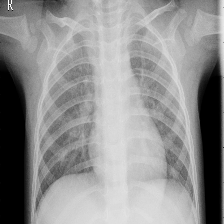

In [ ]:
img = cv2.imread(train_raw+'/PNEUMONIA/BACTERIA-4577721-0001.jpeg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (224,224))
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [255, 255, 255],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [255, 255, 255],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [255, 255, 255],
        [  0,   0,   0]]], dtype=uint8)
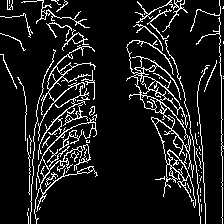

In [ ]:
apply_canny(img)

array([[[ 2,  2,  2],
        [23, 23, 23],
        [17, 17, 17],
        ...,
        [ 0,  0,  0],
        [ 7,  7,  7],
        [ 0,  0,  0]],

       [[21, 21, 21],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 7,  7,  7],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 6,  6,  6],
        [30, 30, 30],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 4,  4,  4],
        [16, 16, 16],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 7,  7,  7],
        [ 1,  1,  1],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [22, 22, 22],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)
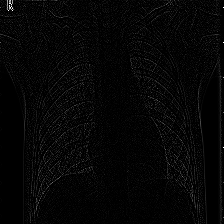

In [ ]:
apply_laplacian(img)

array([[[ 23,  23,  23],
        [ 23,  23,  23],
        [ 26,  26,  26],
        ...,
        [210, 210, 210],
        [223, 223, 223],
        [238, 238, 238]],

       [[ 23,  23,  23],
        [ 27,  27,  27],
        [ 33,  33,  33],
        ...,
        [209, 209, 209],
        [230, 230, 230],
        [236, 236, 236]],

       [[ 28,  28,  28],
        [ 26,  26,  26],
        [ 40,  40,  40],
        ...,
        [210, 210, 210],
        [224, 224, 224],
        [238, 238, 238]],

       ...,

       [[  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3],
        ...,
        [ 68,  68,  68],
        [117, 117, 117],
        [180, 180, 180]],

       [[  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3],
        ...,
        [ 68,  68,  68],
        [121, 121, 121],
        [174, 174, 174]],

       [[  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3],
        ...,
        [ 61,  61,  61],
        [123, 123, 123],
        [174, 174, 174]]], dtype=uint8)
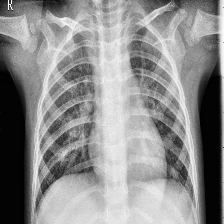

In [ ]:
apply_clahe(img)

In [ ]:
X_train, y_train, filters_train = process_and_dataframe(train_raw, train_proc, apply_filters=True)

2025-08-25 05:12:43 - [INFO] - Processing /content/drive/MyDrive/data/files/chest_xray/chest_xray_train/PNEUMONIA...
INFO:Data-Handler:Processing /content/drive/MyDrive/data/files/chest_xray/chest_xray_train/PNEUMONIA...
Processing PNEUMONIA:  13%|█▎        | 497/3882 [02:10<01:37, 34.75img/s]2025-08-25 05:14:54 - [INFO] - Chunk commit: pushing 500 images to permanent storage and clearing buffers...
INFO:Data-Handler:Chunk commit: pushing 500 images to permanent storage and clearing buffers...
Processing PNEUMONIA:  26%|██▌       | 998/3882 [02:24<01:16, 37.92img/s]2025-08-25 05:15:08 - [INFO] - Chunk commit: pushing 500 images to permanent storage and clearing buffers...
INFO:Data-Handler:Chunk commit: pushing 500 images to permanent storage and clearing buffers...
Processing PNEUMONIA:  39%|███▊      | 1496/3882 [02:37<00:58, 41.07img/s]2025-08-25 05:15:21 - [INFO] - Chunk commit: pushing 500 images to permanent storage and clearing buffers...
INFO:Data-Handler:Chunk commit: pushing 

In [ ]:
# save filtered image dataset
# np.savez_compressed("/content/drive/MyDrive/data/files/processed_chest_xray/filters_train.npz", **filters_train)

In [ ]:
loaded = np.load("/content/drive/MyDrive/data/files/processed_chest_xray/filters_train.npz", allow_pickle=True)
filters_train = {k: loaded[k] for k in loaded.files}


In [ ]:
# # save ytrain
# np.save("/content/drive/MyDrive/data/files/processed_chest_xray/y_train.npy", y_train)

# # load
y_train = np.load("/content/drive/MyDrive/data/files/processed_chest_xray/y_train.npy")

In [ ]:
test_raw = "/content/drive/MyDrive/data/files/chest_xray/chest_xray_test"
test_proc = "/content/drive/MyDrive/data/files/processed_chest_xray/chest_xray_test"

X_test, y_test, filters_test = process_and_dataframe(test_raw, test_proc, apply_filters=True)

2025-08-27 05:21:59 - [INFO] - Processing /content/drive/MyDrive/data/files/chest_xray/chest_xray_test/PNEUMONIA...
INFO:Data-Handler:Processing /content/drive/MyDrive/data/files/chest_xray/chest_xray_test/PNEUMONIA...
Processing PNEUMONIA: 100%|██████████| 390/390 [02:44<00:00,  2.37img/s]
2025-08-27 05:24:46 - [INFO] - Completed /content/drive/MyDrive/data/files/chest_xray/chest_xray_test/PNEUMONIA!
INFO:Data-Handler:Completed /content/drive/MyDrive/data/files/chest_xray/chest_xray_test/PNEUMONIA!
2025-08-27 05:24:46 - [INFO] - Processing /content/drive/MyDrive/data/files/chest_xray/chest_xray_test/NORMAL...
INFO:Data-Handler:Processing /content/drive/MyDrive/data/files/chest_xray/chest_xray_test/NORMAL...
Processing NORMAL:  47%|████▋     | 109/234 [00:50<00:43,  2.87img/s]2025-08-27 05:25:37 - [INFO] - Chunk commit: pushing 500 images to permanent storage and clearing buffers...
INFO:Data-Handler:Chunk commit: pushing 500 images to permanent storage and clearing buffers...
Processi

In [ ]:
processed_dir = '/content/drive/MyDrive/data/files/processed_chest_xray/chest_xray_train'
X_train=[]
for cls in ['PNEUMONIA', 'NORMAL']:
    cls_proc = os.path.join(processed_dir, cls)
    for im in tqdm(os.listdir(cls_proc), f'Working on {cls}:'):
        X_train.append(cv2.imread(os.path.join(cls_proc, im)))


X_train = np.array(X_train, dtype=np.uint8)

Working on NORMAL:: 100%|██████████| 1349/1349 [00:32<00:00, 41.99it/s] 


# Before building main model, lets test `ResNet50` on raw dataset and filterred dataset

In [ ]:
def build_resnet(input_shape=(224,224,3), num_classes=2):
    base = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    base.trainable = False

    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [ ]:
def train_model(X_train, y_train, X_val, y_val, input_shape=(224,224,3), num_classes=2, epochs=10, batch_size=32):
    model = build_resnet(input_shape, num_classes)

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("outputs/resnet_model.keras", save_best_only=True)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return model, history


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    y_pred = np.argmax(preds, axis=1)

    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    acc = (y_pred == y_test).mean()
    print(f"Test Accuracy: {acc:.4f}")
    return acc


In [ ]:
# Train
model, history = train_model(X_train, y_train, X_test, y_test, input_shape=X_train.shape[1:], num_classes=2, epochs=10)

# Evaluate
acc = evaluate_model(model, X_test, y_test)

Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - accuracy: 0.7961 - loss: 0.4554 - val_accuracy: 0.8253 - val_loss: 0.4071
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - accuracy: 0.9356 - loss: 0.1570 - val_accuracy: 0.8397 - val_loss: 0.4094
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.9547 - loss: 0.1259 - val_accuracy: 0.8718 - val_loss: 0.3343
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.9609 - loss: 0.0963 - val_accuracy: 0.8702 - val_loss: 0.3444
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.9683 - loss: 0.0854 - val_accuracy: 0.8574 - val_loss: 0.3781
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - accuracy: 0.9723 - loss: 0.0721 - val_accuracy: 0.8638 - val_loss: 0.3861
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80       234
           1       0.84      0.98      0.91

In [ ]:
# Train
model1, history1 = train_model(filters_train['clahe'], y_train, filters_test['clahe'], y_test, input_shape=X_train.shape[1:], num_classes=2, epochs=10)

# Evaluate
acc1 = evaluate_model(model1, filters_test['clahe'], y_test)

Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 43s 195ms/step - accuracy: 0.7711 - loss: 0.5284 - val_accuracy: 0.7804 - val_loss: 0.4757
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.9245 - loss: 0.1839 - val_accuracy: 0.8317 - val_loss: 0.4206
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.9478 - loss: 0.1353 - val_accuracy: 0.8638 - val_loss: 0.3572
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.9500 - loss: 0.1236 - val_accuracy: 0.8686 - val_loss: 0.3354
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.9565 - loss: 0.1095 - val_accuracy: 0.8365 - val_loss: 0.4282
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - accuracy: 0.9571 - loss: 0.1081 - val_accuracy: 0.8926 - val_loss: 0.2590
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.9674 - loss: 0.0874 - val_accuracy: 0.8814 - val_loss: 0.3202
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.9670 - loss: 0.0913 

# To be done: Model compariosn, (Will try vgg16, mobilenetv2, densenet121)